## Programming assignment 2A: Political stance classification

### Part 3: Implementing your classifier

In [157]:
# load the data
import pandas as pd

# clean the data
import numpy as np
from collections import Counter

# baseline classifier
from sklearn.dummy import DummyClassifier
# several classification algorithms
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# for converting training and test datasets into matrices
# TfidfVectorizer does this specifically for documents
from sklearn.feature_extraction.text import TfidfVectorizer

# for splitting the dataset into training and test sets
# and for selecting model hyperparameters
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# for evaluating the quality of the classifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
# the training data (final set 13,520 instances))
df_f = pd.read_csv('a2a_train_final.tsv', sep = '\t', header=None, names=['Annotation', 'Comment'])
df_f.head()

,Annotation,Comment
0,1/1,... people who have NEVER voted... sneaky way ...
1,0/0,Being a member of the European Union is a bit ...
2,0/0,Brexit is bad. Immigrants make Britain great. ...
3,0/0,Britain is basically Pompeii if the Pompeii ha...
4,1/1,Britain's exit is a huge blow to the dream of ...


In [5]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13517 entries, 0 to 13516
Data columns (total 2 columns):
Annotation    13517 non-null object
Comment       13517 non-null object
dtypes: object(2)
memory usage: 211.3+ KB


We have two solutions for choosing the annotation to use. Both of them choose the annotation if there is only one and both chooses the one that is not -1 in case of tie.

The first one is below. If there is disagreement between the annotations, this one picks the first annotation. This is a good solution assuming that there are some characteristics that are hard to recognize for the people but maybe easier for the computer. The first annotator had the context of the text so we can trust his/her choice.

In [136]:
score = df_f["Annotation"]
# more strict version
newScore1 = []
toRemove1 = []
# less strict version
newScore2 = []
index = 0
clearScores = 0
for annot in score:
    
    votes = annot.split("/")
    majority = Counter()
    
    # Counter object to count the occurences of different annotations
    for vote in votes:
        majority[vote] += 1
        
    # if there is a clear winner, go with it
    if len(majority)==1:
        newScore1.append(majority.most_common()[0][0])
        newScore2.append(majority.most_common()[0][0])
        clearScores += 1
    else:
        # if there if one score with more counts than any other
        if majority.most_common()[0][1] > majority.most_common()[1][1]:
            # and that count is not -1 we get it as newScore
            if int(majority.most_common()[0][0])!=-1:
                newScore1.append(majority.most_common()[0][0])
                newScore2.append(majority.most_common()[0][0])
            else:
                # if it is -1 we either remove the row
                toRemove1.append(index)
                # or keep the clear score
                newScore2.append(majority.most_common()[1][0])
        # if there are two scores with same counts and one of them is -1
        # we keep the clear call
        elif len(majority)==2: 
            if int(majority.most_common()[1][0])==-1:
                newScore1.append(majority.most_common()[0][0])  
                newScore2.append(majority.most_common()[0][0])  
            elif int(majority.most_common()[0][0])==-1:
                newScore1.append(majority.most_common()[1][0])  
                newScore2.append(majority.most_common()[1][0])
            else:
                # if no -1, but disagreement we remove
                toRemove1.append(index)
                # if there is a tie between 0 and 1 we keep the original
                newScore2.append(votes[0])
        else:
            # in any other case we remove the row from the strict version
            toRemove1.append(index)
            # but in the less strict version we keep some more:
            # if there is a tie between 0 and 1 we keep the original
            newScore2.append(votes[0])
    
    index += 1

In [137]:
print("There are " + str(clearScores) + " clear scores out of " + str(len(df_f['Annotation']))) 
print("In the more strict case we remove " + str(len(toRemove1)))
print("In the less strict case we remove " + '0')

There are 11005 clear scores out of 13517
In the more strict case we remove 1107
In the less strict case we remove 0


In [138]:
X_strict = df_f["Comment"].drop(toRemove1)

Y_strict = newScore1

X_train_s, X_eval_s, Y_train_s, Y_eval_s = train_test_split(X_strict, Y_strict,
                                                    test_size = 0.2,
                                                    random_state=12345)

In [139]:
np.unique(Y_strict)

array(['0', '1'], dtype='<U1')

In [355]:
# Count all words appear in 'pro-Brexit (1)' and 'anti-Brexit (0)' labels
w_count = {}
w_pro = []
w_anti = []
freqs_pro = Counter()
freqs_anti = Counter()

for i in range(len(Y_strict)):  
    if Y_strict[i] == '1':
        w_pro.append(words[i])
    else:
        w_anti.append(words[i])
w_count['w_pro'] = sum([len(p) for p in w_pro])
w_count['w_anti'] = sum([len(n) for n in w_anti])

# Count how many times each word appears in 'pro-Brexit (1)' or 'anti-Brexit (0)' documents

for doc in w_pro:
    for p in doc:
        freqs_pro[p] += 1
for doc in w_anti:
      for n in doc:
            freqs_anti[n] += 1

#print(w_count)
#print(freqs_pro)
#print(freqs_anti)

print("**Highest scoring words in pro-Brexit: ")
print()
print(freqs_pro.most_common(20))
print()
print("**Highest scoring words in anti-Brexit: ")
print()
print(freqs_anti.most_common(20))

**Highest scoring words in pro-Brexit: 

[('the', 9534), ('to', 5316), ('and', 4187), ('of', 3802), ('a', 3581), ('is', 2860), ('in', 2330), ('I', 2019), ('for', 1905), ('EU', 1898), ('that', 1783), ('be', 1556), ('will', 1533), ('we', 1412), ('have', 1307), ('are', 1267), ('it', 1239), ('The', 1211), ('they', 1062), ('with', 1035)]

**Highest scoring words in anti-Brexit: 

[('the', 9235), ('to', 5310), ('and', 4177), ('of', 3641), ('a', 3539), ('is', 2745), ('in', 2387), ('I', 1999), ('EU', 1826), ('for', 1801), ('that', 1734), ('will', 1648), ('be', 1608), ('we', 1395), ('The', 1302), ('have', 1298), ('it', 1278), ('are', 1256), ('Brexit', 1182), ('UK', 1037)]


In [140]:
X_lose = df_f["Comment"]

Y_lose = newScore2

X_train_l, X_eval_l, Y_train_l, Y_eval_l = train_test_split(X_lose, Y_lose,
                                                    test_size = 0.2,
                                                    random_state=12345)

In [141]:
np.unique(Y_lose)

array(['0', '1'], dtype='<U1')

First, we apply TF-IDF vectorization on training and test comments

In [148]:
dv1 = TfidfVectorizer()
X_train_trans_s = dv1.fit_transform(X_train_s)
X_eval_trans_s = dv1.transform(X_eval_s)
dv2 = TfidfVectorizer()
X_train_trans_l = dv2.fit_transform(X_train_l)
X_eval_trans_l = dv2.transform(X_eval_l)
dv3 = TfidfVectorizer()
X_s_trans = dv3.fit_transform(X_strict)
dv4 = TfidfVectorizer()
X_l_trans = dv4.fit_transform(X_lose)

We train different classifiers on the more and less strictly pre-processed training set.

In [143]:
# First, we train the dummy classifier to have a baseline
def train_dummy(X, Y, X_eval_trans):
    clf = DummyClassifier()
    clf.fit(X,Y)
    training_score = clf.score(X, Y)
    dummy_pred = clf.predict(X_eval_trans)
    return training_score, dummy_pred

We aim to select the best classifier by calculating training and prediction accuracy as well as using GridSearch cross validation

In [76]:
def train_NB(X, Y, X_eval_trans):
    clf = MultinomialNB()
    clf.fit(X,Y)
    training_score = clf.score(X, Y)
    nb_pred = clf.predict(X_eval_trans)
    return training_score, nb_pred

In [77]:
def train_SVC(X, Y, X_eval_trans):
    clf = LinearSVC()
    clf.fit(X,Y)
    training_score = clf.score(X, Y)
    svc_pred = clf.predict(X_eval_trans)
    return training_score, svc_pred

In [78]:
def train_SGD(X, Y, X_eval_trans):
    clf = SGDClassifier()
    clf.fit(X,Y)
    training_score = clf.score(X, Y)
    sgd_pred = clf.predict(X_eval_trans)
    return training_score, sgd_pred

In [79]:
#using Gradient boosting
def train_GB(X, Y, X_eval_trans):
    clf = GradientBoostingClassifier()
    clf.fit(X, Y)
    training_score = clf.score(X, Y)
    gb_pred = clf.predict(X_eval_trans)
    return training_score, gb_pred

In [85]:
#using Decision Tree
def train_DT(X, Y, X_eval_trans):
    clf = DecisionTreeClassifier()
    clf.fit(X, Y)
    training_score = clf.score(X, Y)
    dt_pred = clf.predict(X_eval_trans)
    return training_score, dt_pred

In [94]:
#using Logistic Regression
def train_LR(X, Y, X_eval_trans):
    clf = LogisticRegression(solver='lbfgs')
    clf.fit(X, Y)
    training_score = clf.score(X, Y)
    lr_pred = clf.predict(X_eval_trans)
    return training_score, lr_pred

In [160]:
def GSCV(X, Y, scores, tp_SVC, tp_NB, tp_SGD, tp_GB, tp_DT, tp_LR):    
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print("Support vector classifier: ")
        clf_SVC = GridSearchCV(SVC(), tp_SVC, scoring='%s_macro' % score)
        param_scores(X, Y, clf_SVC)
        print("Naive Bayes classifier: ")
        clf_NB = GridSearchCV(MultinomialNB(), tp_NB, scoring='%s_macro' % score)
        param_scores(X, Y, clf_NB)
        print("Stochastic Gradient Descent classifier: ")
        clf_SGD = GridSearchCV(SGDClassifier(), tp_SGD, scoring='%s_macro' % score)
        param_scores(X, Y, clf_SGD)
        print("Gradient Boosting classifier: ")
        clf_GB = GridSearchCV(GradientBoostingClassifier(), tp_GB, scoring='%s_macro' % score)
        param_scores(X, Y, clf_GB)
        print("Decision Tree classifier: ")
        clf_DT = GridSearchCV(DecisionTreeClassifier(), tp_DT, scoring='%s_macro' % score)
        param_scores(X, Y, clf_DT)
        print("Logisic Regression classifier: ")
        clf_LR = GridSearchCV(LogisticRegression(), tp_LR, scoring='%s_macro' % score)
        param_scores(X, Y, clf_LR)

In [154]:
def param_scores(X, Y, clf):
    clf.fit(X, Y)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [145]:
def training_all(X_train_trans, Y_train, X_eval_trans, Y_eval):
    print("Training scores: ")
    
    dummy_training_score, dummy_pred = train_dummy(X_train_trans,Y_train, X_eval_trans)
    print("Dummy training score is " + str(dummy_training_score))
    NB_training_score, NB_pred = train_NB(X_train_trans,Y_train, X_eval_trans)
    print("Naive Bayes training score is " + str(NB_training_score))
    SVC_training_score, SVC_pred =  train_SVC(X_train_trans,Y_train, X_eval_trans)
    print("Support Vector Classifier training score is " + str(SVC_training_score))
    SGDC_training_score, SGDC_pred =  train_SGD(X_train_trans,Y_train, X_eval_trans)
    print("Stochastic Gradient Descent training score is " + str(SGDC_training_score))
    GB_training_score, GB_pred =  train_GB(X_train_trans,Y_train, X_eval_trans)
    print("Gradient Boosting training score is " + str(GB_training_score))
    DT_training_score, DT_pred =  train_DT(X_train_trans,Y_train, X_eval_trans)
    print("Decision Tree training score is " + str(DT_training_score))
    LR_training_score, LR_pred =  train_LR(X_train_trans,Y_train, X_eval_trans)
    print("Logistic Regression training score is " + str(LR_training_score))
    
    print()
    print("The highest training score is " + 
          str(max(dummy_training_score, NB_training_score, SVC_training_score, 
             SGDC_training_score, GB_training_score, DT_training_score, LR_training_score)))
    
    print()
    print("Accuracy scores: ")
    
    dummy_acc = accuracy_score(Y_eval, dummy_pred)
    NB_acc = accuracy_score(Y_eval, NB_pred)
    SVC_acc = accuracy_score(Y_eval, SVC_pred)
    SGDC_acc = accuracy_score(Y_eval, SGDC_pred)
    GB_acc = accuracy_score(Y_eval, GB_pred)
    DT_acc = accuracy_score(Y_eval, DT_pred)
    LR_acc = accuracy_score(Y_eval, LR_pred)


    print('     |  true  |  false ')
    print('----------------------')
    print('dummy| {:.4f} | {:.4f}'.format(dummy_acc, (1-dummy_acc)))
    print('  NB | {:.4f} | {:.4f}'.format(NB_acc, (1-NB_acc)))
    print(' SVC | {:.4f} | {:.4f}'.format(SVC_acc, (1-SVC_acc)))
    print('SGDC | {:.4f} | {:.4f}'.format(SGDC_acc, (1-SGDC_acc)))
    print(' GB  | {:.4f} | {:.4f}'.format(GB_acc, (1-GB_acc)))
    print(' DT  | {:.4f} | {:.4f}'.format(DT_acc, (1-DT_acc)))
    print(' LR  | {:.4f} | {:.4f}'.format(LR_acc, (1-LR_acc)))

    print()
    print("The highest prediction score is " + 
          str(max(dummy_acc, NB_acc, SVC_acc, SGDC_acc, GB_acc, DT_acc, LR_acc)))
    
    print()
    print("Examples: ")
    
    #print(X_eval[0:10])
    print("The truth is: ")
    print('Y  : ' + ' '.join(Y_eval[0:10]))
    print("Predictions are: ")
    print('dum: ' + ' '.join(dummy_pred[0:10]))
    print('NB : ' + ' '.join(NB_pred[0:10]))
    print('SVC: '+ ' '.join(SVC_pred[0:10]))
    print('SGD: '+ ' '.join(SGDC_pred[0:10]))
    print('GB : '+' '.join(GB_pred[0:10]))
    print('DT : '+' '.join(DT_pred[0:10]))
    print('LR : '+' '.join(LR_pred[0:10]))
    
    print()
    print("Confusion matrices: ")
    
    print("Naive Bayes: ")
    print(confusion_matrix(Y_eval, NB_pred))
    print("Support Vector: ")
    print(confusion_matrix(Y_eval, SVC_pred))
    print("Stochastic Gradient Descent: ")
    print(confusion_matrix(Y_eval, SGDC_pred))
    print("Gradient Boosting: ")
    print(confusion_matrix(Y_eval, GB_pred))
    print("Decision Tree: ")
    print(confusion_matrix(Y_eval, DT_pred))
    print("Logistic Regression: ")
    print(confusion_matrix(Y_eval, LR_pred))

In [146]:
print("STRICT")
print()
training_all(X_train_trans_s, Y_train_s, X_eval_trans_s, Y_eval_s)
print()
print('-----------------------------------------------')
print()
print("LOOSE")
training_all(X_train_trans_l, Y_train_l, X_eval_trans_l, Y_eval_l)


STRICT

Training scores: 
Dummy training score is 0.4992949234488316
Naive Bayes training score is 0.8845688960515713
Support Vector Classifier training score is 0.9510475423045931
Stochastic Gradient Descent training score is 0.8972602739726028
Gradient Boosting training score is 0.7601732473811442
Decision Tree training score is 0.9998992747784046
Logistic Regression training score is 0.8583803384367445

The highest training score is 0.9998992747784046

Accuracy scores: 
     |  true  |  false 
----------------------
dummy| 0.5060 | 0.4940
  NB | 0.7877 | 0.2123
 SVC | 0.7764 | 0.2236
SGDC | 0.7824 | 0.2176
 GB  | 0.7139 | 0.2861
 DT  | 0.6495 | 0.3505
 LR  | 0.7776 | 0.2224

The highest prediction score is 0.7876712328767124

Examples: 
4271     I do not want to be part of federal Europe. We...
5775     In our opinion, Britain can find a lot of reso...
2654     Dont be fooled by Leavers saying Remain have i...
10590    This is the moment for us to change - to fight...
7458          

In [165]:
tuned_parameters_NB = [{'alpha': [0, 1, 100], 'fit_prior':[True, False]}]
tuned_parameters_SVC = [{'kernel': ['rbf'], 'gamma': [0.1, 1, 10],
                     'C': [0.5, 1, 5, 10]},
                    {'kernel': ['linear'], 'C': [0.5, 1, 5, 10]}]
tuned_parameters_SGD = [{'loss':['hinge','perceptron','modified_huber'],
                         'penalty':['l2','l1'],'max_iter':[5, 10]}]
tuned_parameters_GB = [{'loss':['deviance','exponential'],
                        'learning_rate':[0.1, 0.2],
                        'max_depth':[3, 5, 10]}]
tuned_parameters_DT = [{'criterion':['gini','entropy'],
                        'splitter':['best','random'],
                        'max_depth':[3, 5, 10]}]
tuned_parameters_LR = [{'penalty':['none','l2'], 'C':[0.1, 0.5, 1.0],
                        'class_weight':[None, 'balanced'],
                        'solver':['lbfgs']}]
scores = ['precision', 'recall']

In [166]:
print("STRICT")
print()
GSCV(X_s_trans, Y_strict, scores, tuned_parameters_SVC, tuned_parameters_NB, 
     tuned_parameters_SGD, tuned_parameters_GB, tuned_parameters_DT,
     tuned_parameters_LR)
print()
print('-----------------------------------------------')
print()
print("LOOSE")
GSCV(X_l_trans, Y_lose, scores, tuned_parameters_SVC, tuned_parameters_NB, 
     tuned_parameters_SGD, tuned_parameters_GB, tuned_parameters_DT,
     tuned_parameters_LR)

STRICT

# Tuning hyper-parameters for precision
Support vector classifier: 


/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'C': 5, 'gamma': 1, 'kernel': 'rbf'}
Grid scores on development set:
0.738 (+/-0.012) for {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
0.760 (+/-0.008) for {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
0.757 (+/-0.000) for {'C': 0.5, 'gamma': 10, 'kernel': 'rbf'}
0.751 (+/-0.007) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.769 (+/-0.013) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.716 (+/-0.059) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.762 (+/-0.017) for {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
0.777 (+/-0.019) for {'C': 5, 'gamma': 1, 'kernel': 'rbf'}
0.719 (+/-0.055) for {'C': 5, 'gamma': 10, 'kernel': 'rbf'}
0.765 (+/-0.018) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.777 (+/-0.018) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.719 (+/-0.055) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.758 (+/-0.016) for {'C': 0.5, 'kernel': 'linear'}
0.761 (+/-0.017) for {'C': 1, 'kernel': 'linear'}
0.750 (+/-0.018) for {'C': 5, 'kernel': 'linear'}
0.7

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, sett

Best parameters set found on development set:
{'alpha': 1, 'fit_prior': False}
Grid scores on development set:
0.713 (+/-0.014) for {'alpha': 0, 'fit_prior': True}
0.714 (+/-0.010) for {'alpha': 0, 'fit_prior': False}
0.765 (+/-0.019) for {'alpha': 1, 'fit_prior': True}
0.766 (+/-0.016) for {'alpha': 1, 'fit_prior': False}
0.718 (+/-0.025) for {'alpha': 100, 'fit_prior': True}
0.721 (+/-0.010) for {'alpha': 100, 'fit_prior': False}
Stochastic Gradient Descent classifier: 


/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Best parameters set found on development set:
{'loss': 'hinge', 'max_iter': 10, 'penalty': 'l2'}
Grid scores on development set:
0.761 (+/-0.017) for {'loss': 'hinge', 'max_iter': 5, 'penalty': 'l2'}
0.758 (+/-0.012) for {'loss': 'hinge', 'max_iter': 5, 'penalty': 'l1'}
0.763 (+/-0.017) for {'loss': 'hinge', 'max_iter': 10, 'penalty': 'l2'}
0.759 (+/-0.014) for {'loss': 'hinge', 'max_iter': 10, 'penalty': 'l1'}
0.725 (+/-0.017) for {'loss': 'perceptron', 'max_iter': 5, 'penalty': 'l2'}
0.677 (+/-0.032) for {'loss': 'perceptron', 'max_iter': 5, 'penalty': 'l1'}
0.724 (+/-0.009) for {'loss': 'perceptron', 'max_iter': 10, 'penalty': 'l2'}
0.682 (+/-0.008) for {'loss': 'perceptron', 'max_iter': 10, 'penalty': 'l1'}
0.751 (+/-0.010) for {'loss': 'modified_huber', 'max_iter': 5, 'penalty': 'l2'}
0.741 (+/-0.013) for {'loss': 'modified_huber', 'max_iter': 5, 'penalty': 'l1'}
0.758 (+/-0.026) for {'loss': 'modified_huber', 'max_iter': 10, 'penalty': 'l2'}
0.730 (+/-0.016) for {'loss': 'modifie

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 10}
Grid scores on development set:
0.705 (+/-0.019) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3}
0.716 (+/-0.015) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5}
0.730 (+/-0.015) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10}
0.705 (+/-0.019) for {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3}
0.720 (+/-0.021) for {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 5}
0.730 (+/-0.011) for {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 10}
0.724 (+/-0.018) for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 3}
0.727 (+/-0.025) for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 5}
0.733 (+/-0.020) for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 10}
0.724 (+/-0.022) for {'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 3}
0.728 (+/-0.023) for {'learning_rate': 0.2, 'lo

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
Grid scores on development set:
0.613 (+/-0.036) for {'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'}
0.591 (+/-0.031) for {'criterion': 'gini', 'max_depth': 3, 'splitter': 'random'}
0.615 (+/-0.031) for {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}
0.622 (+/-0.099) for {'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}
0.643 (+/-0.012) for {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
0.624 (+/-0.032) for {'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}
0.614 (+/-0.025) for {'criterion': 'entropy', 'max_depth': 3, 'splitter': 'best'}
0.607 (+/-0.015) for {'criterion': 'entropy', 'max_depth': 3, 'splitter': 'random'}
0.615 (+/-0.032) for {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}
0.614 (+/-0.046) for {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}
0.627 (+/-0.029) for {'criterion': 'entropy', 'ma

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:9

Best parameters set found on development set:
{'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Grid scores on development set:
0.715 (+/-0.011) for {'C': 0.1, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}
0.732 (+/-0.010) for {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
0.714 (+/-0.012) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'none', 'solver': 'lbfgs'}
0.735 (+/-0.013) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
0.715 (+/-0.011) for {'C': 0.5, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}
0.756 (+/-0.008) for {'C': 0.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
0.714 (+/-0.012) for {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'none', 'solver': 'lbfgs'}
0.756 (+/-0.008) for {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
0.715 (+/-0.011) for {'C': 1.0, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}
0.7

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'C': 5, 'gamma': 1, 'kernel': 'rbf'}
Grid scores on development set:
0.732 (+/-0.008) for {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
0.757 (+/-0.004) for {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
0.501 (+/-0.001) for {'C': 0.5, 'gamma': 10, 'kernel': 'rbf'}
0.748 (+/-0.004) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.769 (+/-0.012) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.505 (+/-0.001) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.762 (+/-0.017) for {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
0.777 (+/-0.019) for {'C': 5, 'gamma': 1, 'kernel': 'rbf'}
0.506 (+/-0.000) for {'C': 5, 'gamma': 10, 'kernel': 'rbf'}
0.765 (+/-0.019) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.777 (+/-0.018) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.506 (+/-0.000) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.758 (+/-0.015) for {'C': 0.5, 'kernel': 'linear'}
0.761 (+/-0.018) for {'C': 1, 'kernel': 'linear'}
0.750 (+/-0.019) for {'C': 5, 'kernel': 'linear'}
0.7

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, sett

Best parameters set found on development set:
{'alpha': 1, 'fit_prior': False}
Grid scores on development set:
0.713 (+/-0.014) for {'alpha': 0, 'fit_prior': True}
0.714 (+/-0.010) for {'alpha': 0, 'fit_prior': False}
0.761 (+/-0.021) for {'alpha': 1, 'fit_prior': True}
0.765 (+/-0.017) for {'alpha': 1, 'fit_prior': False}
0.585 (+/-0.011) for {'alpha': 100, 'fit_prior': True}
0.686 (+/-0.016) for {'alpha': 100, 'fit_prior': False}
Stochastic Gradient Descent classifier: 


/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Best parameters set found on development set:
{'loss': 'hinge', 'max_iter': 5, 'penalty': 'l2'}
Grid scores on development set:
0.763 (+/-0.018) for {'loss': 'hinge', 'max_iter': 5, 'penalty': 'l2'}
0.756 (+/-0.017) for {'loss': 'hinge', 'max_iter': 5, 'penalty': 'l1'}
0.763 (+/-0.019) for {'loss': 'hinge', 'max_iter': 10, 'penalty': 'l2'}
0.759 (+/-0.016) for {'loss': 'hinge', 'max_iter': 10, 'penalty': 'l1'}
0.721 (+/-0.013) for {'loss': 'perceptron', 'max_iter': 5, 'penalty': 'l2'}
0.687 (+/-0.035) for {'loss': 'perceptron', 'max_iter': 5, 'penalty': 'l1'}
0.722 (+/-0.017) for {'loss': 'perceptron', 'max_iter': 10, 'penalty': 'l2'}
0.653 (+/-0.006) for {'loss': 'perceptron', 'max_iter': 10, 'penalty': 'l1'}
0.748 (+/-0.020) for {'loss': 'modified_huber', 'max_iter': 5, 'penalty': 'l2'}
0.732 (+/-0.005) for {'loss': 'modified_huber', 'max_iter': 5, 'penalty': 'l1'}
0.755 (+/-0.016) for {'loss': 'modified_huber', 'max_iter': 10, 'penalty': 'l2'}
0.733 (+/-0.015) for {'loss': 'modified

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 10}
Grid scores on development set:
0.702 (+/-0.017) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3}
0.717 (+/-0.016) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5}
0.730 (+/-0.011) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10}
0.702 (+/-0.016) for {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3}
0.715 (+/-0.018) for {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 5}
0.725 (+/-0.016) for {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 10}
0.722 (+/-0.017) for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 3}
0.727 (+/-0.020) for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 5}
0.728 (+/-0.023) for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 10}
0.721 (+/-0.023) for {'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 3}
0.729 (+/-0.019) for {'learning_rate': 0.2, 

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
Grid scores on development set:
0.584 (+/-0.014) for {'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'}
0.560 (+/-0.064) for {'criterion': 'gini', 'max_depth': 3, 'splitter': 'random'}
0.597 (+/-0.021) for {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}
0.577 (+/-0.015) for {'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}
0.633 (+/-0.005) for {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
0.608 (+/-0.024) for {'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}
0.579 (+/-0.024) for {'criterion': 'entropy', 'max_depth': 3, 'splitter': 'best'}
0.577 (+/-0.029) for {'criterion': 'entropy', 'max_depth': 3, 'splitter': 'random'}
0.598 (+/-0.022) for {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}
0.572 (+/-0.043) for {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}
0.614 (+/-0.025) for {'criterion': 'entropy', 'ma

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:9

Best parameters set found on development set:
{'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Grid scores on development set:
0.714 (+/-0.011) for {'C': 0.1, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}
0.730 (+/-0.007) for {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
0.714 (+/-0.012) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'none', 'solver': 'lbfgs'}
0.730 (+/-0.008) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
0.714 (+/-0.011) for {'C': 0.5, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}
0.754 (+/-0.009) for {'C': 0.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
0.714 (+/-0.012) for {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'none', 'solver': 'lbfgs'}
0.754 (+/-0.006) for {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
0.714 (+/-0.011) for {'C': 1.0, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}
0.7

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Grid scores on development set:
0.724 (+/-0.010) for {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
0.742 (+/-0.006) for {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
0.755 (+/-0.000) for {'C': 0.5, 'gamma': 10, 'kernel': 'rbf'}
0.735 (+/-0.006) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.751 (+/-0.009) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.666 (+/-0.052) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.742 (+/-0.006) for {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
0.754 (+/-0.010) for {'C': 5, 'gamma': 1, 'kernel': 'rbf'}
0.665 (+/-0.061) for {'C': 5, 'gamma': 10, 'kernel': 'rbf'}
0.738 (+/-0.011) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.755 (+/-0.009) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.665 (+/-0.061) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.741 (+/-0.010) for {'C': 0.5, 'kernel': 'linear'}
0.740 (+/-0.008) for {'C': 1, 'kernel': 'linear'}
0.723 (+/-0.003) for {'C': 5, 'kernel': 'linear'}
0.

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, sett

Best parameters set found on development set:
{'alpha': 1, 'fit_prior': False}
Grid scores on development set:
0.698 (+/-0.008) for {'alpha': 0, 'fit_prior': True}
0.698 (+/-0.006) for {'alpha': 0, 'fit_prior': False}
0.746 (+/-0.015) for {'alpha': 1, 'fit_prior': True}
0.748 (+/-0.015) for {'alpha': 1, 'fit_prior': False}
0.709 (+/-0.013) for {'alpha': 100, 'fit_prior': True}
0.710 (+/-0.013) for {'alpha': 100, 'fit_prior': False}
Stochastic Gradient Descent classifier: 


/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Best parameters set found on development set:
{'loss': 'hinge', 'max_iter': 10, 'penalty': 'l2'}
Grid scores on development set:
0.740 (+/-0.017) for {'loss': 'hinge', 'max_iter': 5, 'penalty': 'l2'}
0.738 (+/-0.005) for {'loss': 'hinge', 'max_iter': 5, 'penalty': 'l1'}
0.740 (+/-0.007) for {'loss': 'hinge', 'max_iter': 10, 'penalty': 'l2'}
0.740 (+/-0.008) for {'loss': 'hinge', 'max_iter': 10, 'penalty': 'l1'}
0.696 (+/-0.011) for {'loss': 'perceptron', 'max_iter': 5, 'penalty': 'l2'}
0.652 (+/-0.027) for {'loss': 'perceptron', 'max_iter': 5, 'penalty': 'l1'}
0.698 (+/-0.014) for {'loss': 'perceptron', 'max_iter': 10, 'penalty': 'l2'}
0.666 (+/-0.015) for {'loss': 'perceptron', 'max_iter': 10, 'penalty': 'l1'}
0.732 (+/-0.008) for {'loss': 'modified_huber', 'max_iter': 5, 'penalty': 'l2'}
0.712 (+/-0.022) for {'loss': 'modified_huber', 'max_iter': 5, 'penalty': 'l1'}
0.732 (+/-0.009) for {'loss': 'modified_huber', 'max_iter': 10, 'penalty': 'l2'}
0.715 (+/-0.011) for {'loss': 'modifie

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 10}
Grid scores on development set:
0.695 (+/-0.018) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3}
0.706 (+/-0.017) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5}
0.713 (+/-0.014) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10}
0.693 (+/-0.014) for {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3}
0.708 (+/-0.016) for {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 5}
0.716 (+/-0.018) for {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 10}
0.708 (+/-0.018) for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 3}
0.716 (+/-0.008) for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 5}
0.714 (+/-0.014) for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 10}
0.710 (+/-0.018) for {'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 3}
0.717 (+/-0.012) for {'learning_rate': 0.2, 

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'criterion': 'entropy', 'max_depth': 10, 'splitter': 'random'}
Grid scores on development set:
0.601 (+/-0.030) for {'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'}
0.589 (+/-0.017) for {'criterion': 'gini', 'max_depth': 3, 'splitter': 'random'}
0.611 (+/-0.027) for {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}
0.614 (+/-0.029) for {'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}
0.626 (+/-0.012) for {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
0.614 (+/-0.021) for {'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}
0.600 (+/-0.030) for {'criterion': 'entropy', 'max_depth': 3, 'splitter': 'best'}
0.590 (+/-0.037) for {'criterion': 'entropy', 'max_depth': 3, 'splitter': 'random'}
0.608 (+/-0.033) for {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}
0.597 (+/-0.048) for {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}
0.620 (+/-0.025) for {'criterion': 'entropy'

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:9

Best parameters set found on development set:
{'C': 1.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Grid scores on development set:
0.681 (+/-0.011) for {'C': 0.1, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}
0.717 (+/-0.005) for {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
0.684 (+/-0.013) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'none', 'solver': 'lbfgs'}
0.721 (+/-0.008) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
0.681 (+/-0.011) for {'C': 0.5, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}
0.739 (+/-0.006) for {'C': 0.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
0.684 (+/-0.013) for {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'none', 'solver': 'lbfgs'}
0.739 (+/-0.009) for {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
0.681 (+/-0.011) for {'C': 1.0, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}
0.746 (+/

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Grid scores on development set:
0.717 (+/-0.011) for {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
0.740 (+/-0.003) for {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
0.501 (+/-0.001) for {'C': 0.5, 'gamma': 10, 'kernel': 'rbf'}
0.732 (+/-0.002) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.750 (+/-0.008) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.505 (+/-0.001) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.742 (+/-0.006) for {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
0.754 (+/-0.010) for {'C': 5, 'gamma': 1, 'kernel': 'rbf'}
0.505 (+/-0.001) for {'C': 5, 'gamma': 10, 'kernel': 'rbf'}
0.738 (+/-0.012) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.755 (+/-0.009) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.505 (+/-0.001) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.740 (+/-0.009) for {'C': 0.5, 'kernel': 'linear'}
0.740 (+/-0.008) for {'C': 1, 'kernel': 'linear'}
0.722 (+/-0.003) for {'C': 5, 'kernel': 'linear'}
0.

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, sett

Best parameters set found on development set:
{'alpha': 1, 'fit_prior': False}
Grid scores on development set:
0.698 (+/-0.008) for {'alpha': 0, 'fit_prior': True}
0.698 (+/-0.006) for {'alpha': 0, 'fit_prior': False}
0.744 (+/-0.016) for {'alpha': 1, 'fit_prior': True}
0.747 (+/-0.015) for {'alpha': 1, 'fit_prior': False}
0.620 (+/-0.019) for {'alpha': 100, 'fit_prior': True}
0.687 (+/-0.018) for {'alpha': 100, 'fit_prior': False}
Stochastic Gradient Descent classifier: 


/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Best parameters set found on development set:
{'loss': 'hinge', 'max_iter': 10, 'penalty': 'l1'}
Grid scores on development set:
0.738 (+/-0.008) for {'loss': 'hinge', 'max_iter': 5, 'penalty': 'l2'}
0.735 (+/-0.003) for {'loss': 'hinge', 'max_iter': 5, 'penalty': 'l1'}
0.739 (+/-0.009) for {'loss': 'hinge', 'max_iter': 10, 'penalty': 'l2'}
0.739 (+/-0.009) for {'loss': 'hinge', 'max_iter': 10, 'penalty': 'l1'}
0.693 (+/-0.020) for {'loss': 'perceptron', 'max_iter': 5, 'penalty': 'l2'}
0.648 (+/-0.017) for {'loss': 'perceptron', 'max_iter': 5, 'penalty': 'l1'}
0.694 (+/-0.025) for {'loss': 'perceptron', 'max_iter': 10, 'penalty': 'l2'}
0.646 (+/-0.056) for {'loss': 'perceptron', 'max_iter': 10, 'penalty': 'l1'}
0.728 (+/-0.005) for {'loss': 'modified_huber', 'max_iter': 5, 'penalty': 'l2'}
0.706 (+/-0.011) for {'loss': 'modified_huber', 'max_iter': 5, 'penalty': 'l1'}
0.732 (+/-0.005) for {'loss': 'modified_huber', 'max_iter': 10, 'penalty': 'l2'}
0.712 (+/-0.000) for {'loss': 'modifie

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 5}
Grid scores on development set:
0.693 (+/-0.009) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3}
0.704 (+/-0.010) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5}
0.711 (+/-0.010) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10}
0.691 (+/-0.007) for {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3}
0.704 (+/-0.009) for {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 5}
0.714 (+/-0.013) for {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 10}
0.708 (+/-0.015) for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 3}
0.717 (+/-0.016) for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 5}
0.713 (+/-0.010) for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 10}
0.709 (+/-0.013) for {'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 3}
0.718 (+/-0.013) for {'learning_rate': 0.2, '

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
Grid scores on development set:
0.578 (+/-0.010) for {'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'}
0.584 (+/-0.056) for {'criterion': 'gini', 'max_depth': 3, 'splitter': 'random'}
0.598 (+/-0.018) for {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}
0.573 (+/-0.054) for {'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}
0.614 (+/-0.004) for {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
0.600 (+/-0.024) for {'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}
0.577 (+/-0.010) for {'criterion': 'entropy', 'max_depth': 3, 'splitter': 'best'}
0.568 (+/-0.016) for {'criterion': 'entropy', 'max_depth': 3, 'splitter': 'random'}
0.590 (+/-0.021) for {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}
0.584 (+/-0.011) for {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}
0.604 (+/-0.015) for {'criterion': 'entropy', 'ma

/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kata/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:9

Best parameters set found on development set:
{'C': 1.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Grid scores on development set:
0.681 (+/-0.011) for {'C': 0.1, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}
0.715 (+/-0.003) for {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
0.683 (+/-0.013) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'none', 'solver': 'lbfgs'}
0.716 (+/-0.007) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
0.681 (+/-0.011) for {'C': 0.5, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}
0.738 (+/-0.005) for {'C': 0.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
0.683 (+/-0.013) for {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'none', 'solver': 'lbfgs'}
0.737 (+/-0.006) for {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
0.681 (+/-0.011) for {'C': 1.0, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}
0.745 (+/

In [168]:
print(X_strict[2654])
print(X_strict[7458])

Dont be fooled by Leavers saying Remain have it in the bag! Please make sure you vote! Vote Remain #VoteRemain Its common sense #StrongerIn
Nope, not changed my mind. Brexit please...


In [343]:
# build a pipeline using the final classifer SVC
pipeline = make_pipeline(
    TfidfVectorizer(),
    SVC(C=5,gamma=1,kernel='rbf'))

#training using the final classifer (strict data)
strict = pipeline.fit(X_strict, Y_strict);

In [344]:
#loading the test set
df_ts = pd.read_csv('a2a_test_final.tsv', sep = '\t', header=None, names=['Annotation', 'Comment'])
df_ts.head()

,Annotation,Comment
0,0,I didn't think about the business side - Every...
1,0,I had to trigger Article 50. It would have bee...
2,0,Uh we want to leave the EU but we want to keep...
3,1,#DeathtotheEU oh wow I really hate the #EU Wha...
4,1,#IVotedLeave and I hope you did too! #EUref le...


In [346]:
#convert test data to other forms for later using
Xt_f = df_ts['Comment'].astype(str).values.tolist()
Yt_f = np.array(df_ts['Annotation'].astype(str).values.tolist())

In [347]:
#prediction using the test set
pred_strict = strict.predict(Xt_f)
strict_accuracy = accuracy_score(Yt_f, pred_strict)
print('strict_accuracy: ' + str(strict_accuracy))

strict_accuracy: 0.8275862068965517


In [348]:
#confusion matrix for prediction

confusion_matrix(pred_strict, Yt_f)

array([[450, 106],
       [ 94, 510]])

In [349]:
# calculate precision_recall_fscore
print('SVC precision: ' + str(precision_recall_fscore_support(pred_strict, Yt_f, average='macro')[0]))
print('SVC recall: ' + str(precision_recall_fscore_support(pred_strict, Yt_f, average='macro')[1]))
print('SVC fscore: ' + str(precision_recall_fscore_support(pred_strict, Yt_f, average='macro')[2]))

SVC precision: 0.8275639801375095
SVC recall: 0.8268616894563818
SVC fscore: 0.827123695976155


In [350]:
#splitting words in comments using (X_lose)
words = []
for line in X_lose:
    word = line.strip().split()
    words.append(word)
print(words[1:5])

[['Being', 'a', 'member', 'of', 'the', 'European', 'Union', 'is', 'a', 'bit', 'like', 'going', 'to', 'a', 'sandwich', 'shop', 'and', 'buying', 'a', '£3', 'sandwich', 'with', 'a', '£5', 'note', 'and', 'getting', 'back', 'over', '£1,000', 'in', 'change'], ['Brexit', 'is', 'bad.', 'Immigrants', 'make', 'Britain', 'great.', 'They', 'also', 'cooked', 'your', 'food', 'The', 'London', 'restaurant', 'causing', 'a', 'stir', 'with', 'anti-#Brexit', 'messages', 'on', 'your', 'bill'], ['Britain', 'is', 'basically', 'Pompeii', 'if', 'the', 'Pompeii', 'had', 'voted', 'for', 'the', 'volcano', '...', "I'm", 'DEAD!', ':p'], ["Britain's", 'exit', 'is', 'a', 'huge', 'blow', 'to', 'the', 'dream', 'of', 'a', 'united', 'Europe', 'No.', 'It', 'is', 'the', 'end', 'of', 'an', 'anti-national,', 'centralized,', 'globalist,', 'neoliberal', 'and', 'authoritarian', 'system', 'and', 'organism', 'like', 'the', 'EU', 'and', 'its', 'hegemonic', 'power', 'over', 'Europe.']]


Text(0.5, 0, 'Figure 1: ROC curve for SVC classifier')

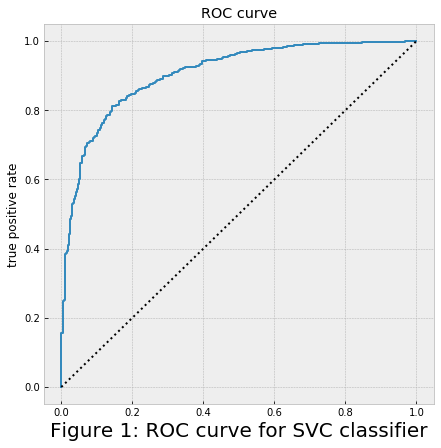

In [359]:
# ROC curve
plt.style.use('bmh')

scores = loose.decision_function(Xt_f)
fprs, tprs, _ = roc_curve(Yt_f, scores, pos_label='1')

plt.figure(figsize=(7,7))
plt.plot(fprs, tprs)

plt.plot([0, 1], 'k:')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

roc_auc_score(Yt_f =='1', scores)
plt.title('ROC curve')
plt.xlabel('Figure 1: ROC curve for SVC classifier', fontsize=20)

0.0940126050420168

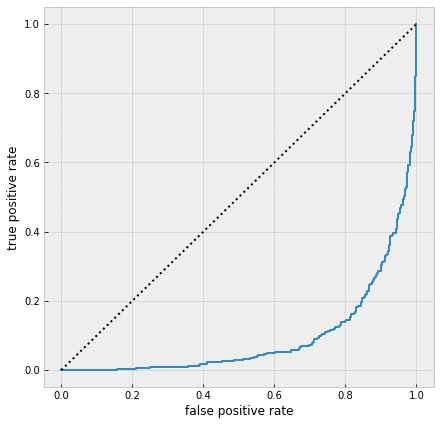

In [354]:
fprs, tprs, _ = roc_curve(Yt_f, scores, pos_label='0')

plt.figure(figsize=(7,7))
plt.plot(fprs, tprs)

plt.plot([0, 1], 'k:')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

roc_auc_score(Yt_f=='0', scores)